# Imports

Imports and Environment Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

import math

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

# Caltech101 data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize(256),
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    ])

batch_size = 1

num_workers = 1

kaggle_dataset_path = '/kaggle/input/caltech101/101_ObjectCategories'

trainset = torchvision.datasets.ImageFolder(root=kaggle_dataset_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root=kaggle_dataset_path, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
import os
classes = [d.name for d in os.scandir(kaggle_dataset_path) if d.is_dir()]
classes.sort()
len(classes)

101

In [ ]:
t2im = transforms.ToPILImage()
im2t = transforms.PILToTensor()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 3, 224, 224]) Motorbikes


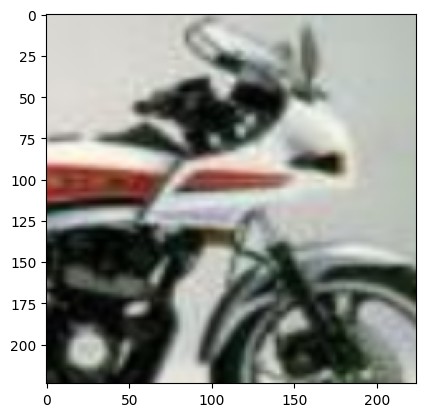

In [ ]:
# visualizing sample image
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    plt.imshow(t2im(inputs.squeeze()))
    print(inputs.shape, classes[labels])
    break

# Load SAM

In [ ]:
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-83tit1ln
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-83tit1ln
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2024-02-03 20:03:42--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.121, 18.164.78.72, 18.164.78.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: 'sam_vit_h_4b8939.pth.1'

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   261MB/s    in 9.9s    

2024-02-03 20:03:52 (247 MB/s) - 'sam_vit_h_4b8939.pth.1' saved [2564550879/2564550879]



In [ ]:
!pip install umap-learn

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('Device:', device)

sam = sam_model_registry["vit_h"](checkpoint="/kaggle/working/sam_vit_h_4b8939.pth")
sam.to(device)

# sam predictor
predictor = SamPredictor(sam)

# sam mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

Device: cuda


In [ ]:
# function to show annotations
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.9]])
        img[m] = color_mask
    ax.imshow(img)

# Extract embeddings for the image (Caltech101)

In [ ]:
embeddings = [] # to store image embeddings
truths = [] # to store ground truth labels


# iterating through all images in the train set
for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    # Convert the PyTorch tensor to a NumPy array
    image_np = inputs.squeeze().numpy()

    # Convert from channels-last (C, H, W) to channels-first (H, W, C)
    image_np = np.transpose(image_np, (1, 2, 0))

    # Scale to 0-255
    image_np = (image_np * 255).astype(np.uint8)

    image = image_np

    # generate patch-wise embeddings for the image
    mask_generator.predictor.set_image(image)
    patch_emb = mask_generator.predictor.features
    patch_emb = patch_emb.to('cpu').numpy()
    patch_emb = patch_emb[0].transpose((1,2,0))

    # generate embedding for entire image
    # image embeddding is an average of the patch-wise embeddings
    # each image is represented by a 256-dimensional embedding vector
    img_emb = np.mean(patch_emb, axis=(0, 1))

    print('===========================================')
    embeddings.append(img_emb)
    print('labels', labels)
    print('class label', classes[labels])
    truths.append(classes[labels])
    print('truths len:', len(truths))
    print('truths:', truths[len(truths) - 1])
    print('===========================================')

In [ ]:
# Save embeddings to a file
with open('/kaggle/working/embeddings.txt', 'w') as f:
    for emb in embeddings:
        f.write(f'{emb}\n')

# Save truths to a file
with open('/kaggle/working/truths.txt', 'w') as f:
    for truth in truths:
        f.write(f'{truth}\n')

# LDA

In [ ]:
# Reading truths from file
def read_classes(file_path):
    classes = []
    with open(file_path, 'r') as file:
        for line in file:
            classes.append(line.strip())
    return classes

truths = read_classes('/kaggle/working/truths.txt')

In [ ]:
# Reading embeddings from file
def read_embeddings(file_path):
    embeddings = []
    current_embedding = []
    with open(file_path, 'r') as file:
        for line in file:
            clean_line = line.strip()

            if clean_line.startswith('['):
                clean_line = clean_line[1:]

            elements = clean_line.split()

            if clean_line.endswith(']'):
                elements[-1] = elements[-1].replace(']', '')
                current_embedding.extend([float(e) for e in elements])
                embeddings.append(np.array(current_embedding))
                current_embedding = []
            else:
                current_embedding.extend([float(e) for e in elements])

    return embeddings

embeddings = read_embeddings('/kaggle/working/embeddings.txt')

In [ ]:
print(len(embeddings))
print(embeddings[0].shape)
print(len(truths))

8677
(256,)
8677


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(np.asarray(embeddings), truths, test_size=0.2, random_state=18)

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

In [ ]:
X_train.shape

(6941, 256)

In [ ]:
# Fit the LDA model on the training data
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [ ]:
# Transform the data using the LDA model
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [ ]:
X_train_lda.shape

(6941, 100)

In [ ]:
# Train a classifier on the transformed data (you can use any classifier of your choice)
# Here, we'll use a simple logistic regression classifier
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_lda)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6209677419354839


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


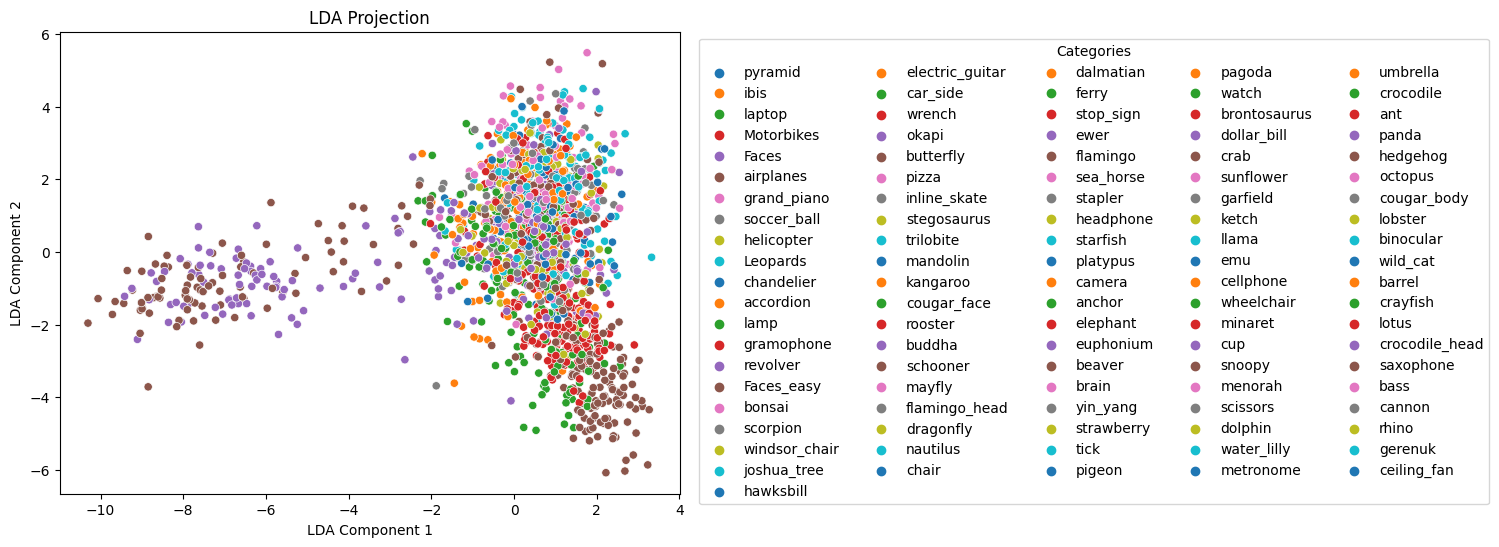

In [ ]:
# Assuming X_lda is the transformed data and y is the class labels
plt.figure(figsize=(8, 6))
plot = sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=y_test, palette='tab10', legend=True)
plot.legend(loc='upper left', bbox_to_anchor=(1.02, 1), ncol=5, title='Categories')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.show()

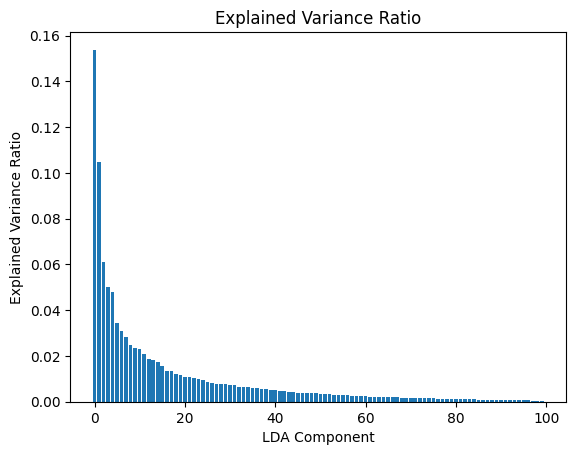

In [ ]:
plt.bar(range(len(lda.explained_variance_ratio_)), lda.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.xlabel('LDA Component')
plt.ylabel('Explained Variance Ratio')
plt.show()